___

<div style="text-align: center;">
  <span style="font-family: 'Playfair Display', serif; font-size: 24px; font-weight: bold;">
Dataset Exploration
  </span>
</div>

___


In this notebook, we will explore four datasets stored in DuckDB using PySpark. The datasets include the Criminal Dataset, Airbnb Listings, TripAdvisor Attractions, and Restaurants. 

The exploration will involve:

<li>Identification of Data Quality rules on the datasets</li>
<li>Assessment of the Quality of the Data</li>
<li>Application of Data Cleaning processes (individually per dataset)</li>
<li>Expression of Data quality rules as Denial Constraints</li>
<li>Storage of the improved quality tables in the Trusted Zone, mirroring the tables in the Formatted Zone</li>

In [1]:
#%pip install duckdb pyspark folium geopy wordcloud unidecode rdflib 
#!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
#!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS pyspark_postgres;'
#!sudo -u postgres psql -U postgres -c 'CREATE DATABASE pyspark_postgres;'
#!wget -O "postgresql.jar" "https://repo1.maven.org/maven2/org/postgresql/postgresql/42.7.3/postgresql-42.7.3.jar"
#!wget -O "duckdb.jar" "https://repo1.maven.org/maven2/org/duckdb/duckdb_jdbc/0.10.1/duckdb_jdbc-0.10.1.jar"

In [2]:
## Imports
import duckdb
import pickle
import folium
import warnings
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, concat_ws, split, col, count, isnan, when
warnings.filterwarnings("ignore")

import sys
import os

current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

# Agregate the dic to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
import utils

## Connection to formatted database
jdbc_url = 'jdbc:duckdb:./../data/formatted_zone/barcelona.db'
driver = "org.duckdb.DuckDBDriver"

# SparkSession inicialitzation
spark = SparkSession.builder \
    .config("spark.jars", "./../lib/duckdb.jar") \
    .appName("DataExploration") \
    .getOrCreate()

24/06/03 17:46:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/03 17:46:32 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
        <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold; color: black;">
            TripAdvisor Locations Dataset
        </span>
    </div>
</div>


#### DataFrame Schema

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
The DataFrame comprises various columns, each providing distinct details related to property listings:

The DataFrame has **2493 rows** and **14 columns**. 

- **location_id**: string (nullable = true)
- **name**: string (nullable = true)
- **distance**: string (nullable = true)
- **bearing**: string (nullable = true)
- **address_obj.street1**: string (nullable = true)
- **address_obj.city**: string (nullable = true)
- **address_obj.state**: string (nullable = true)
- **address_obj.country**: string (nullable = true)
- **address_obj.postalcode**: string (nullable = true)
- **address_obj.address_string**: string (nullable = true)
- **address_obj.street2**: string (nullable = true)
- **type**: string (nullable = true)
- **district**: string (nullable = true)
- **__index_level_0__**: decimal(20,0) (nullable = true)
</div>

In [3]:
df_locations = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_tripadvisor_locations") \
  .load()

Replace names with points

In [4]:
exprs = [f"`{col_name}` as `{col_name.replace('.', '_')}`" for col_name in df_locations.columns]
df_locations = df_locations.selectExpr(exprs)

print("The DataFrame has {} rows and {} columns. \n".format(df_locations.count(), len(df_locations.columns)))

The DataFrame has 2493 rows and 14 columns. 



Count Null Values

In [5]:
nan_counts = df_locations.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_locations.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,location_id,name,distance,bearing,address_obj_street1,address_obj_city,address_obj_state,address_obj_country,address_obj_postalcode,address_obj_address_string,address_obj_street2,type,district,__index_level_0__
0,0,0,0,0,47,0,1,0,106,0,1864,0,0,0


The columns that have directly unimputable NA will be simply removed from the data. We will do not want to use them anyway. 
<div class="alert alert-block alert-warning" style="color: #FFB300; background-color: #FFF9C4;">

+ adress_obj_street1, address_obj_postalcode, address_obj_street2 -> These are niether useful or complete; since we will be using coordinates for localization in the future, they will be erased
</div>



In [6]:
columns_to_drop = ["address_obj_street2", "address_obj_postalcode", "address_obj_street1"]
df_locations = df_locations.drop(*columns_to_drop)

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
We know that all restaurants are in the Province of Barcelona, so the 1 NA value we have in the address_obj_state column can be filled with this information

</div>

In [7]:
df_locations = df_locations.fillna({"address_obj_state": "Province of Barcelona"})


<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
For some reason, the TripAdvisor API also included come cities which were not in Barcelona, we will remove those instances
</div>


In [8]:
df_locations.select("address_obj_city").distinct().show()
df_locations = df_locations.filter(df_locations['address_obj_city'] == 'Barcelona')

+--------------------+
|    address_obj_city|
+--------------------+
|              Xativa|
|          Ibiza Town|
|             Peguera|
|Sant Cugat del Va...|
|Sant Andreu de la...|
|            Sabadell|
|           Barcelona|
|   Montcada i Reixac|
|              Sitges|
|L'Hospitalet de L...|
|          La Bordeta|
|            Valencia|
|         Los Abrigos|
|               Cadiz|
|Sant Feliu de Llo...|
+--------------------+



Geolocalization function. Since the adress is not complete in all cases and we want to place all locations in a map, we will also be using data from google maps to exactly localize each establishment. This is probably a step that should be done in the data collection pipeline but since it is a problem we have faced along the way, we will be adressing it here.

<div class="alert alert-block alert-info" style="color: #1E88E5; background-color: #B2EBF2;">

+ We've crafted a geolocation function called `geolocalization_with_retry` to pinpoint addresses using the **Google Maps API** and `address_obj_address_string` feature. This function has the ability to retry geolocation several times in case of initial failure due to errors or timeouts. If successful, it returns the latitude and longitude coordinates of the provided address.

+ We've implemented a mechanism to avoid re-executing the geolocation code for addresses that have already been matched. This is achieved by saving the geolocation results to a file (`coordinates_dict.pkl`) and loading them from there for subsequent executions, preventing unnecessary repetition of the geocoding process.


+ We plotted the geolocations to visually identify any outliers. Then, we defined a square area to limit the zone of Barcelona, excluding any points that fall outside of this area.

</div>


In [9]:
# As it takes too long, it will be saved to a file for separate loading
import requests
import time

def geolocalization_with_retry(address, retries=3, sleep_time=5):
    api_key = '{your_key ;)}'
    url = f"https://maps.googleapis.com/maps/api/geocode/json?address={address}&key={api_key}"

    for attempt in range(retries):
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            if data['status'] == 'OK':
                lat = data['results'][0]['geometry']['location']['lat']
                lng = data['results'][0]['geometry']['location']['lng']
                return (lat, lng)
        time.sleep(sleep_time)  # Espera antes de reintentar
    return None

In [10]:
file_name = "coordinates_dict.pkl"

# Load de retrieved dict
with open(file_name, "rb") as file:
    coordinates_dict = pickle.load(file)

In [11]:
df_coordenadas = spark.createDataFrame(list(coordinates_dict.items()), ['location_id', 'coordinates'])
df_locations = df_locations.join(df_coordenadas, on='location_id', how='left')

In [12]:
df_locations = df_locations \
    .withColumn('coordinates_str', concat_ws(',', col('coordinates._1'), col('coordinates._2'))) \
    .withColumn('latitude', split(col('coordinates_str'), ',').getItem(0).cast('float')) \
    .withColumn('longitude', split(col('coordinates_str'), ',').getItem(1).cast('float')) \
    .drop(*['coordinates_str', 'coordinates'])  

df_locations.limit(2).toPandas()

,location_id,name,distance,bearing,address_obj_city,address_obj_state,address_obj_country,address_obj_address_string,type,district,__index_level_0__,latitude,longitude
0,27200794,Anna Subirats Xarcuteria,0.03857963183663804,east,Barcelona,Province of Barcelona,Spain,"Carrer De Sepulveda, 167, 08011 Barcelona Spain",restaurant,Eixample,190,41.383205,2.162197
1,27326644,Rincon Del Cazador,0.15956806976023746,south,Barcelona,Province of Barcelona,Spain,"Passeig De La Mare De Deu Del Coll, 68, 08023 ...",restaurant,Gràcia,212,41.417217,2.147516


In [13]:
# Limits of Barcelona
barcelona_lat_min = 41.33
barcelona_lat_max = 41.45
barcelona_lng_min = 2.10
barcelona_lng_max = 2.24

map_barcelona = folium.Map(location=[(barcelona_lat_min + barcelona_lat_max) / 2,
                                     (barcelona_lng_min + barcelona_lng_max) / 2], zoom_start=12)

# Square to paint
bounds = [(barcelona_lat_min, barcelona_lng_min),
          (barcelona_lat_min, barcelona_lng_max),
          (barcelona_lat_max, barcelona_lng_max),
          (barcelona_lat_max, barcelona_lng_min),
          (barcelona_lat_min, barcelona_lng_min)]

folium.Polygon(bounds, color='red', fill=True, fill_color='red', fill_opacity=0.5).add_to(map_barcelona)
map_barcelona

In [14]:
# Apply the square
df_locations = df_locations[(df_locations['latitude'] >= barcelona_lat_min) & 
                            (df_locations['latitude'] <= barcelona_lat_max) &
                            (df_locations['longitude'] >= barcelona_lng_min) & 
                            (df_locations['longitude'] <= barcelona_lng_max)]

In [15]:
df_locations.select("type").distinct().show()
df_locations.select("district").distinct().show()
# rename district to match to the other dfs
df_locations = df_locations.withColumnRenamed("district", "neighbourhood")

+----------+
|      type|
+----------+
|attraction|
|restaurant|
+----------+

+-------------------+
|           district|
+-------------------+
|             Gràcia|
|         Sant Martí|
|     Horta-Guinardó|
|          Les Corts|
|     Sants-Montjuïc|
|         Nou Barris|
|Sarrià-Sant Gervasi|
|           Eixample|
|        Sant Andreu|
|       Ciutat Vella|
+-------------------+



Categorical Features Distributions Insights
<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

+ The majority of restaurants and attractions are located between Ciutat Vella and Example, where the highest volume of tourists is found.
+ We have slightly more restaurants than attractions, but the difference is fairly balanced.
</div>

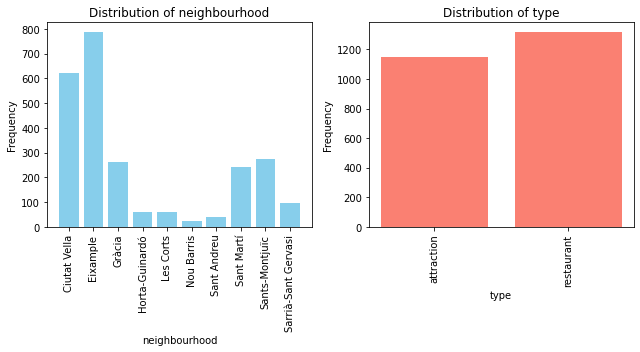

In [18]:
color_palette = ['skyblue', 'salmon', 'lightgreen', 'orange'] # Paleta de colores
fig, axs = plt.subplots(1, 2, figsize=(9, 5))  
axs = axs.flatten() 

for i, column in enumerate(["neighbourhood", "type"]):
    ax = axs[i]  
    color = color_palette[i % len(color_palette)]  
    utils.plot_categorical_distribution(df_locations, column, ax, color)

plt.tight_layout()
plt.show()

In [19]:
nan_counts = df_locations.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_locations.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

,location_id,name,distance,bearing,address_obj_city,address_obj_state,address_obj_country,address_obj_address_string,type,neighbourhood,__index_level_0__,latitude,longitude
0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [20]:
df_locations.printSchema()
df_locations.limit(1).toPandas() 

root
 |-- location_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- bearing: string (nullable = true)
 |-- address_obj_city: string (nullable = true)
 |-- address_obj_state: string (nullable = false)
 |-- address_obj_country: string (nullable = true)
 |-- address_obj_address_string: string (nullable = true)
 |-- type: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- __index_level_0__: decimal(20,0) (nullable = true)
 |-- latitude: float (nullable = true)
 |-- longitude: float (nullable = true)



,location_id,name,distance,bearing,address_obj_city,address_obj_state,address_obj_country,address_obj_address_string,type,neighbourhood,__index_level_0__,latitude,longitude
0,27200794,Anna Subirats Xarcuteria,0.03857963183663804,east,Barcelona,Province of Barcelona,Spain,"Carrer De Sepulveda, 167, 08011 Barcelona Spain",restaurant,Eixample,190,41.383205,2.162197


<div style="background-color:#F2F2F2; padding: 10px;">
    <div style="text-align: center;">
        <span style="font-family: 'Playfair Display', serif; font-size: 20px; font-weight: bold; color: black;">
            TripAdvisor Reviews Datasets
        </span>
    </div>
</div>



#### DataFrame Schema

<div class="alert alert-block alert-info" style="color: #01571B; background-color: #C8E5C6;">
    
The DataFrame comprises various columns, each providing distinct details related to property listings:

- The DataFrame has **5449 rows** and **48 columns**. 

- **location_id**: decimal(20,0) (nullable = true)
- **id**: decimal(20,0) (nullable = true)
- **lang**: string (nullable = true)
- **published_date**: string (nullable = true)
- **rating**: decimal(20,0) (nullable = true)
- **helpful_votes**: decimal(20,0) (nullable = true)
- **rating_image_url**: string (nullable = true)
- **url**: string (nullable = true)
- **text**: string (nullable = true)
- **title**: string (nullable = true)
- **trip_type**: string (nullable = true)
- **travel_date**: string (nullable = true)
- **user_username**: string (nullable = true)
- **user_user_location_id**: string (nullable = true)
- **user_avatar_thumbnail**: string (nullable = true)
- **user_avatar_small**: string (nullable = true)
- **user_avatar_medium**: string (nullable = true)
- **user_avatar_large**: string (nullable = true)
- **user_avatar_original**: string (nullable = true)
- **name**: string (nullable = true)
- **address_obj_address_string**: string (nullable = true)
- **type**: string (nullable = true)
- **neighbourhood**: string (nullable = true)
- **latitude**: float (nullable = true)
- **longitude**: float (nullable = true)
</div>


In [21]:
df_reviews = spark.read \
  .format("jdbc") \
  .option("url", jdbc_url) \
  .option("driver", driver) \
  .option("query", "SELECT * FROM df_tripadvisor_reviews") \
  .load()

Replace names with points

In [22]:
exprs = [f"`{col_name}` as `{col_name.replace('.', '_')}`" for col_name in df_reviews.columns]
df_reviews = df_reviews.selectExpr(exprs)

Explanation for Join Operation

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

We are performing a join operation between `df_reviews` and `df_locations` DataFrames on the 'location_id' column. This is done to filter `df_reviews` to only include rows corresponding to locations that are present in `df_locations`. By using an inner join (`how='inner'`), we ensure that only matching rows from both DataFrames are retained, effectively restricting our analysis to reviews for locations within Barcelona.
</div>


Count the Null Values

In [23]:
nan_counts = df_reviews.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_reviews.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()

24/06/03 17:47:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,id,lang,location_id,published_date,rating,helpful_votes,rating_image_url,url,text,title,...,subratings_3_name,subratings_3_rating_image_url,subratings_3_value,subratings_3_localized_name,owner_response_id,owner_response_title,owner_response_text,owner_response_lang,owner_response_author,owner_response_published_date
0,0,0,0,0,0,0,0,0,0,0,...,5105,5105,5105,5105,5003,5003,5003,5003,5003,5003


Remove redundant columns

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

+ Values with lots of NaN --> drop

We mainly will be only using the scoring of the reviews.
</div>

In [24]:
columns_to_drop = [
    "subratings_0_name",
    "subratings_0_rating_image_url",
    "subratings_0_value",
    "subratings_0_localized_name",
    "subratings_1_name",
    "subratings_1_rating_image_url",
    "subratings_1_value",
    "subratings_1_localized_name",
    "subratings_2_name",
    "subratings_2_rating_image_url",
    "subratings_2_value",
    "subratings_2_localized_name",
    "subratings_3_name",
    "subratings_3_rating_image_url",
    "subratings_3_value",
    "subratings_3_localized_name",
    "owner_response_id",
    "owner_response_title",
    "owner_response_text",
    "owner_response_lang",
    "owner_response_author",
    "owner_response_published_date",
    "user_user_location_name"
]
df_reviews = df_reviews.drop(*columns_to_drop)

<div class="alert alert-block alert-info" style="color: #01579B; background-color: #E1F5FE; border-color: #01579B;">

Some of the other ones could be saved and imputed. For instance "user.user_location.name" could go look the name of the location on the location table. But since we will not be using those, the easiest way to deal with those is by removing them.
</div>

In [25]:
columns_to_drop = [
'trip_type',
'travel_date',
'user.user_location.name',
'user_avatar_thumbnail',
'user_avatar_small',
'user_avatar_medium',
'user_avatar_large',
'user_avatar_original',
]
df_reviews = df_reviews.drop(*columns_to_drop)

In [26]:
# Checking again the NULL values
nan_counts = df_locations.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_locations.columns])
total_nan_count = sum(nan_counts.collect()[0])
nan_counts.toPandas()
columns_with_values_greater_than_zero = nan_counts.toPandas().columns[nan_counts.toPandas().iloc[0] > 0]
columns_with_values_greater_than_zero

Index([], dtype='object')

In [27]:
df_reviews.printSchema()
df_reviews.limit(1).toPandas()

root
 |-- id: decimal(20,0) (nullable = true)
 |-- lang: string (nullable = true)
 |-- location_id: decimal(20,0) (nullable = true)
 |-- published_date: string (nullable = true)
 |-- rating: decimal(20,0) (nullable = true)
 |-- helpful_votes: decimal(20,0) (nullable = true)
 |-- rating_image_url: string (nullable = true)
 |-- url: string (nullable = true)
 |-- text: string (nullable = true)
 |-- title: string (nullable = true)
 |-- user_username: string (nullable = true)
 |-- user_user_location_id: string (nullable = true)



,id,lang,location_id,published_date,rating,helpful_votes,rating_image_url,url,text,title,user_username,user_user_location_id
0,903790935,en,8821646,2023-07-17T19:52:18Z,5,0,https://www.tripadvisor.com/img/cdsi/img2/rati...,https://www.tripadvisor.com/ShowUserReviews-g1...,"Stopped for a light bites chicken, chips, rice...",Good value tasty food.,Wager47,255093


In [28]:
# Prepare the DuckDB connection
con = duckdb.connect(database='./../data/trusted_zone/barcelona_processed.db', read_only=False)
con.close()

## Write on the tables 
print('Writting tables...')
jdbc_url = 'jdbc:duckdb:./../data/trusted_zone/barcelona_processed.db'
driver = "org.duckdb.DuckDBDriver"

print('    - Tripadvisor Locations table')
df_locations.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "df_tripadvisor_locations") \
    .option("driver", driver) \
    .mode("overwrite") \
    .save()

print('    - Tripadvisor Reviews table')
df_reviews.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "df_tripadvisor_reviews") \
    .option("driver", driver) \
    .mode("overwrite") \
    .save()

spark.stop()
con.close()

Writting tables...
    - Tripadvisor Locations table


    - Tripadvisor Reviews table
